In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facenet-model/facenet_keras.h5
/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpcsvkmeuaafdfjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpbpblogspotcomedLMjVpRGkSWexgsXjkNIAAAAAAAADWgFFtAUqBlhAsjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTENDgMDUODczNDcNTcjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/ben_afflek/httpcsvkmeuadecafjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/mindy_kaling/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTIOTcwODQNTUzNjQMzcjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/mindy_kaling/httpcdncdnjustjaredcomwpcontentuploadsheadlinesmindykalingcomedypilotjpg.jpg
/kaggle/input/5-celebrity-faces-dataset/val/mindy_kaling/httpdbrbzkkbdsdcloudfrontnetwpcontentuploadsMindyKalingjpg.jpg
/kaggle/input/5-celebrity-faces-data

# !pip install mtcnn

In [3]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 608 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
from PIL import Image
from numpy import asarray
from mtcnn import MTCNN

In [5]:
boundingBox=[]
def face_detector(filename,size=(160,160)):
    image=Image.open(filename)
    image = image.convert('RGB')
    pixels=asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    boundingBox.append(results[0]['box'])
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    face=pixels[y1:y1+height,x1:x1+width]
    image = Image.fromarray(face)
    image = image.resize(size)
    face_array = asarray(image)
    return face_array

In [6]:
from matplotlib import pyplot as plt
import os
def dataset(folder):
    faces=[]
    labels=[]
    i=1
    for imgfolder in os.listdir('../input/5-celebrity-faces-dataset/'+folder):
        for imgfile in os.listdir('../input/5-celebrity-faces-dataset/'+folder + '/' + imgfolder):
            filename='../input/5-celebrity-faces-dataset/'+folder+'/'+imgfolder+'/'+imgfile
            #print(filename)
            img_array=face_detector(filename)
            labels.append(imgfolder)
            plt.imshow(img_array)
            plt.subplot(15,7,i)
            i=i+1
            faces.append(img_array)
    plt.show()
    return faces,labels

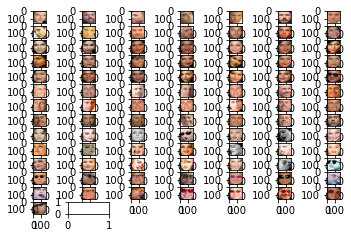

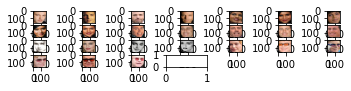

In [7]:
folder1='train'
folder2='val'
trainX,trainY=dataset(folder1)
testX,testY=dataset(folder2)

In [8]:
print(len(trainX),len(trainY),len(testX),len(testY))

93 93 25 25


In [9]:
from keras.models import load_model
model=load_model('../input/facenet-model/facenet_keras.h5')

In [10]:
newtrainX=[]
for i in trainX:
    face_pixels = i.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    embeddings = model.predict(samples)
    embeddings=embeddings.flatten()
    newtrainX.append(embeddings)

In [11]:
newtestX=[]
for i in testX:
    face_pixels = i.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    embeddings = model.predict(samples)
    embeddings=embeddings.flatten()
    newtestX.append(embeddings)

In [12]:
newtrainX=np.asarray(newtrainX)
newtestX=np.asarray(newtestX)

In [13]:
print(newtrainX.shape,newtestX.shape)

(93, 128) (25, 128)


In [14]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

In [15]:
in_encoder = Normalizer(norm='l2')
trainx = in_encoder.transform(newtrainX)
testx = in_encoder.transform(newtestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainY)
trainy = out_encoder.transform(trainY)
testy = out_encoder.transform(testY)

In [16]:
model = SVC(kernel='linear', probability=True)
model.fit(trainx, trainy)
# predict
yhat_train = model.predict(trainx)
yhat_test = model.predict(testx)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


In [17]:
from cv2 import cv2

In [18]:
test_img=[]
image1=[]
boundingBox1=[]
for imgfolder in os.listdir('../input/5-celebrity-faces-dataset/val'):
    for imgfile in os.listdir('../input/5-celebrity-faces-dataset/val' + '/' + imgfolder):
        filename='../input/5-celebrity-faces-dataset/val'+'/'+imgfolder+'/'+imgfile
        #image=cv2.imread(filename)
        image=Image.open(filename)
        image = image.convert('RGB')
        pixels=asarray(image)
        #image1.append(pixels)
        detector = MTCNN()
        results = detector.detect_faces(pixels)
        boundingBox1.append(results[0]['box'])
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        cv2.rectangle(pixels, (x1, y1), (x1+width, y1+height), (255,0,0), 2)
        test_img.append(pixels)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

the predicted person is ben_afflekwith an accuracy of 1.0
the predicted person is ben_afflekwith an accuracy of 1.0
the predicted person is ben_afflekwith an accuracy of 1.0
the predicted person is ben_afflekwith an accuracy of 1.0
the predicted person is ben_afflekwith an accuracy of 1.0
the predicted person is mindy_kalingwith an accuracy of 1.0
the predicted person is mindy_kalingwith an accuracy of 1.0
the predicted person is mindy_kalingwith an accuracy of 1.0
the predicted person is mindy_kalingwith an accuracy of 1.0
the predicted person is mindy_kalingwith an accuracy of 1.0
the predicted person is jerry_seinfeldwith an accuracy of 1.0
the predicted person is jerry_seinfeldwith an accuracy of 1.0


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

the predicted person is jerry_seinfeldwith an accuracy of 1.0
the predicted person is jerry_seinfeldwith an accuracy of 1.0
the predicted person is jerry_seinfeldwith an accuracy of 1.0
the predicted person is madonnawith an accuracy of 1.0
the predicted person is madonnawith an accuracy of 1.0
the predicted person is madonnawith an accuracy of 1.0
the predicted person is madonnawith an accuracy of 1.0
the predicted person is madonnawith an accuracy of 1.0
the predicted person is elton_johnwith an accuracy of 1.0
the predicted person is elton_johnwith an accuracy of 1.0
the predicted person is elton_johnwith an accuracy of 1.0
the predicted person is elton_johnwith an accuracy of 1.0
the predicted person is elton_johnwith an accuracy of 1.0


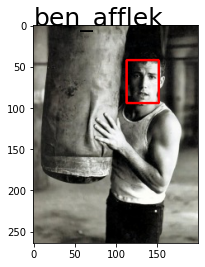

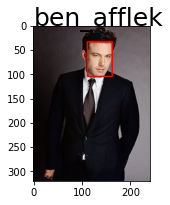

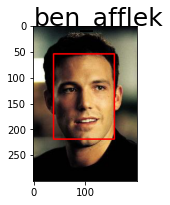

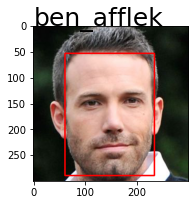

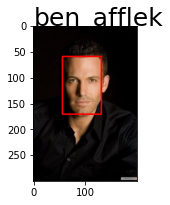

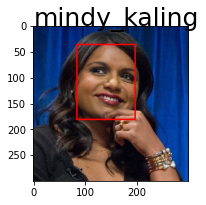

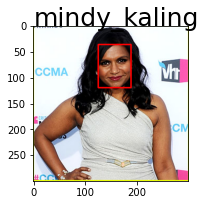

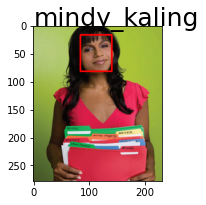

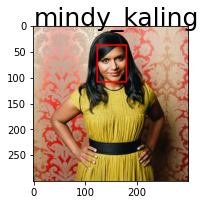

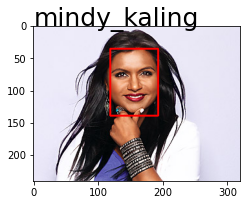

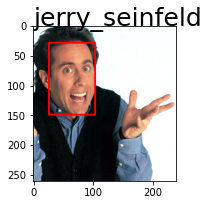

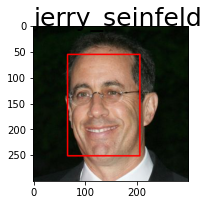

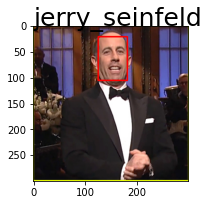

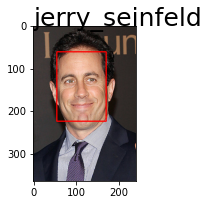

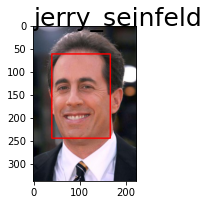

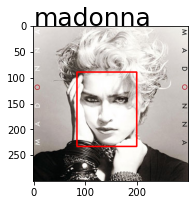

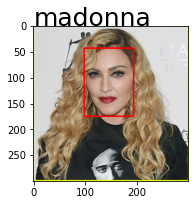

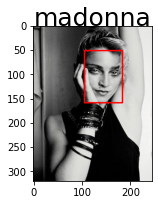

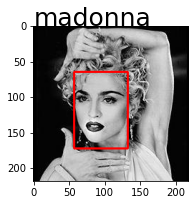

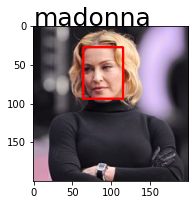

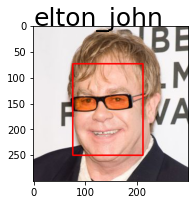

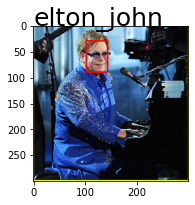

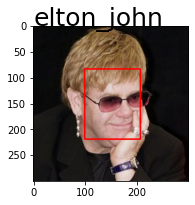

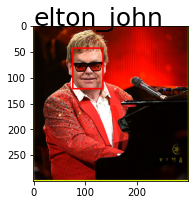

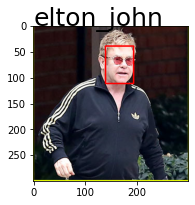

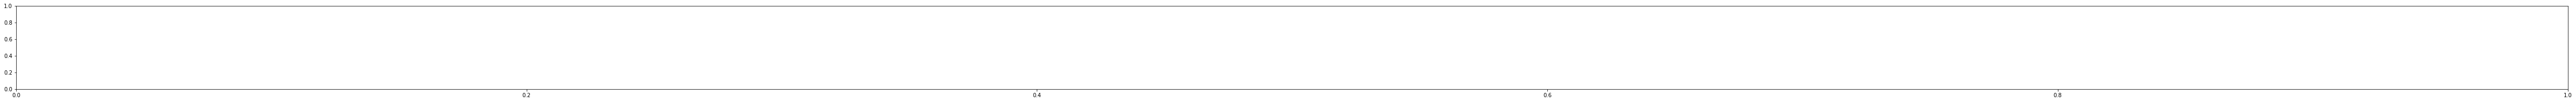

In [19]:
i=1
index=0
for face in testx:
    tst=np.expand_dims(face,axis=0)
    y_hat=model.predict(tst)
    score = accuracy_score(np.array([testy[index]]), y_hat)
    name=out_encoder.inverse_transform([y_hat])
    print('the predicted person is '+str(name[0])+'with an accuracy of '+str(score) )
    plt.text(0,0,name[0],fontsize=25)
    plt.imshow(test_img[index])
    plt.figure(figsize=(85,85))
    plt.subplot(25,1,i)
    i+=1
    index=index+1
plt.show()